# Описание и цели проекта
Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.
Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. 

**Цели проекта:**  
- Провести ad hoc исследование вероятных причин оттока клиентов.
- Найти корреляцию поведенческих признаков с вероятным оттоком клиента. - Построить предиктивную модель для прогнозирования оттока (на уровне следующего месяца) для каждого клиента.

**Задачи:**  
- Сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- Проанализировать основные признаки, наиболее сильно влияющие на отток;
- Сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами.

## 1. Загрузка данных. Предварительный анализ.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
pd.options.display.float_format ='{:,.2f}'.format

In [ ]:
gym_churn = pd.read_csv('/datasets/gym_churn.csv')
gym_churn.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0


Посмотрим на сводную информацию по данным.

In [ ]:
gym_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


В таблице отсутствуют пропуски. Данные предварительно категоризированы по методу "one-hot encoding" и такие поля, как: gender, Near_Location, Partner, Promo_friends, Phone, Group_visits, Churn принимают значения 0 или 1. 

Смотрим есть ли явные дубликаты

In [ ]:
gym_churn.duplicated().sum()

0

## 2. Исследовательский анализ данных (EDA)

Посмотрим на распределение значений в нашем датасете

In [ ]:
gym_churn.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,"4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00"
mean,0.51,0.85,0.49,0.31,0.90,4.68,0.41,29.18,146.94,4.32,3.72,1.88,1.77,0.27
std,0.50,0.36,0.50,0.46,0.30,4.55,0.49,3.26,96.36,4.19,3.75,0.97,1.05,0.44
min,0.00,0.00,0.00,0.00,0.00,1.00,0.00,18.00,0.15,1.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,0.00,0.00,1.00,1.00,0.00,27.00,68.87,1.00,1.00,1.18,0.96,0.00
50%,1.00,1.00,0.00,0.00,1.00,1.00,0.00,29.00,136.22,1.00,3.00,1.83,1.72,0.00
75%,1.00,1.00,1.00,1.00,1.00,6.00,1.00,31.00,210.95,6.00,5.00,2.54,2.51,1.00
max,1.00,1.00,1.00,1.00,1.00,12.00,1.00,41.00,552.59,12.00,31.00,6.02,6.15,1.00


Можно сделать следующие выводы по распределению данных:
* Средний возраст посетителя 29 лет, причем половина всех клиентов приходится на возраст 27-31
* Большая часть клиентов (больше 50%) предпочитают абонементы на 1 месяц. 
* В среднем клиенты посещают зал менее 1-го раза в неделю.
* Также видим, что большая часть клиентов проживают в том же районе, где находится фитнес-центр
* 50% клиентов в выборки посещат фитнес-клуб в течении 3 месяцев.
* Также следует заметить, что признаки имеют разные по величине стандартные отклонения. Следует это учесть на этапе обучения модели.

* Посмотрим на распределение признаков по 2-м группам: тех кто остался (churn=0) и тех, кто ушел (churn=1)

In [ ]:
gym_churn.groupby('Churn').mean().T

Churn,0,1
gender,0.51,0.51
Near_Location,0.87,0.77
Partner,0.53,0.36
Promo_friends,0.35,0.18
Phone,0.90,0.90
Contract_period,5.75,1.73
Group_visits,0.46,0.27
Age,29.98,26.99
Avg_additional_charges_total,158.45,115.08
Month_to_end_contract,5.28,1.66


Посотрим графики для сравнения признаков по 2-м группам.

In [ ]:
plt.style.use('seaborn-pastel')

In [ ]:
gym_churn.columns

Index(['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone',
       'Contract_period', 'Group_visits', 'Age',
       'Avg_additional_charges_total', 'Month_to_end_contract', 'Lifetime',
       'Avg_class_frequency_total', 'Avg_class_frequency_current_month',
       'Churn'],
      dtype='object')

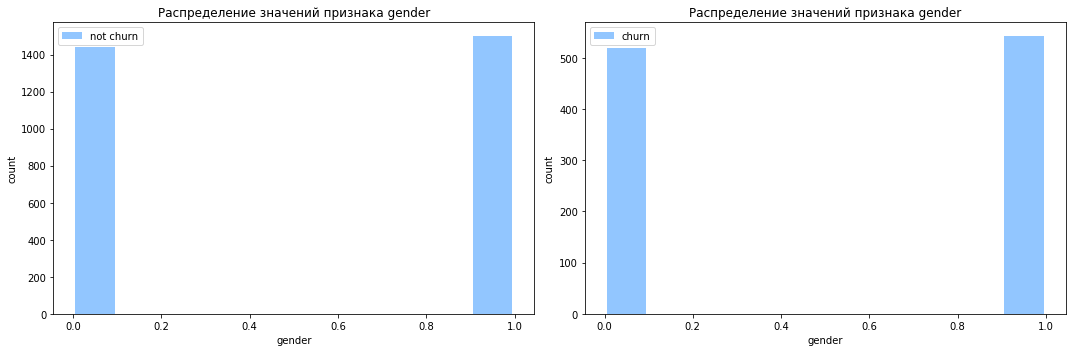

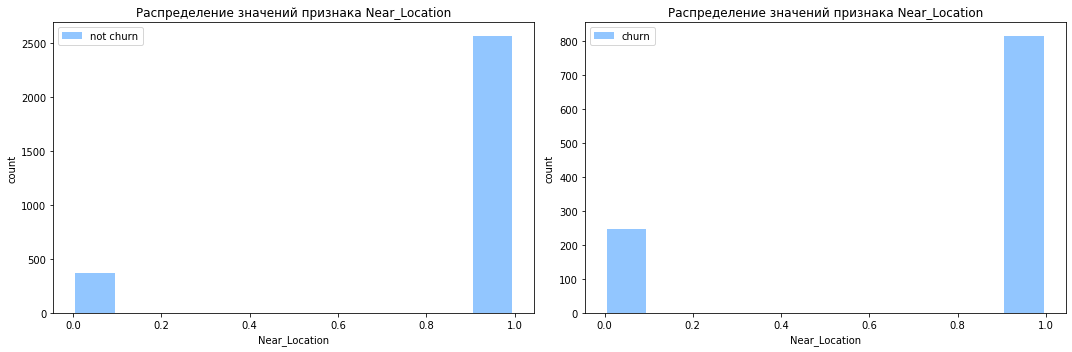

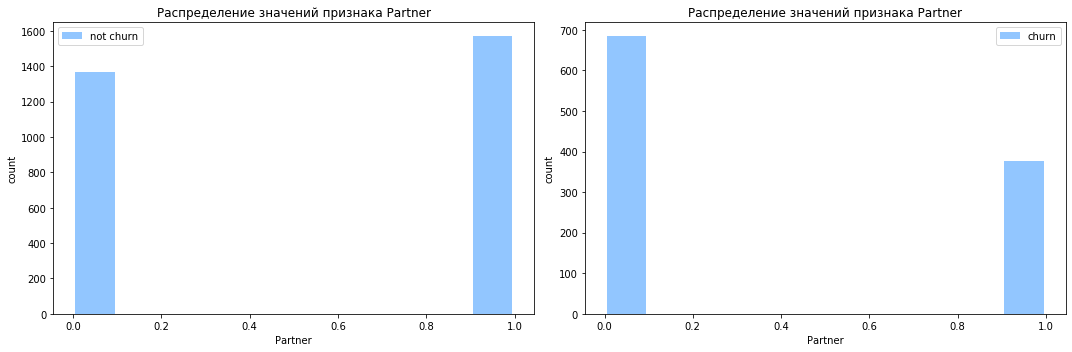

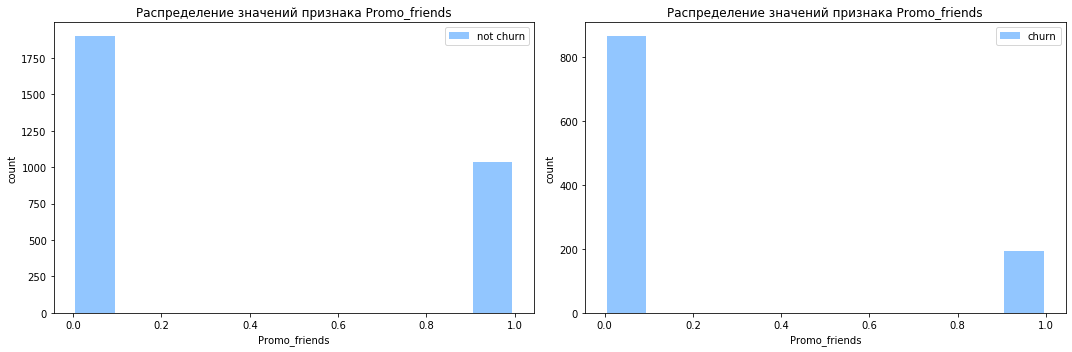

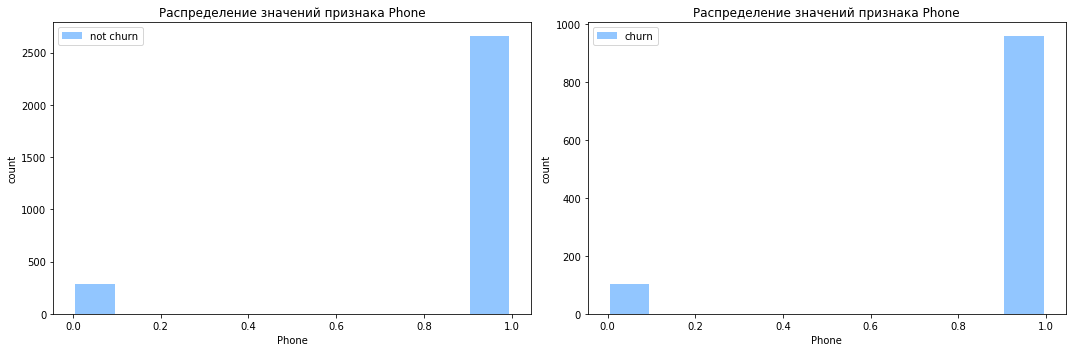

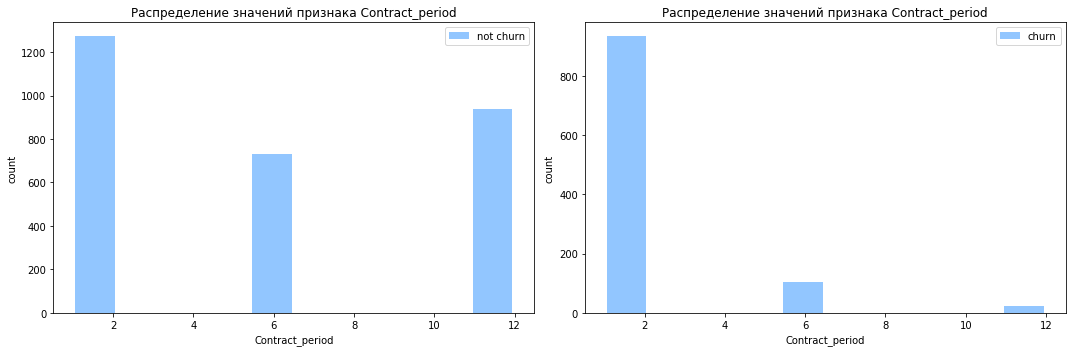

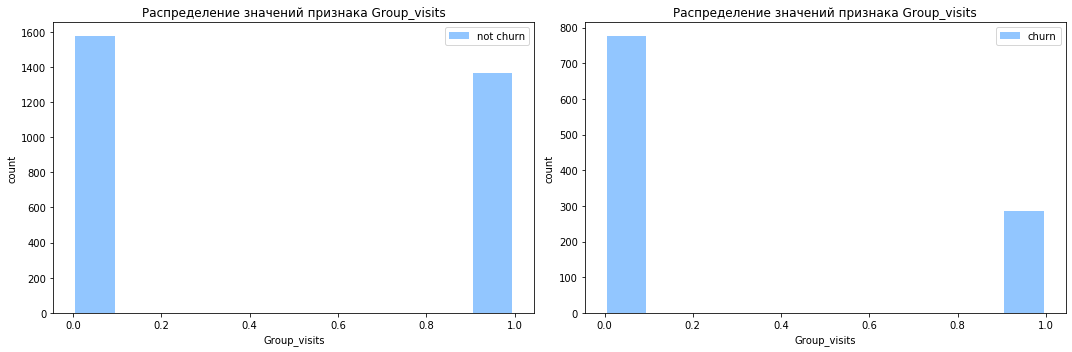

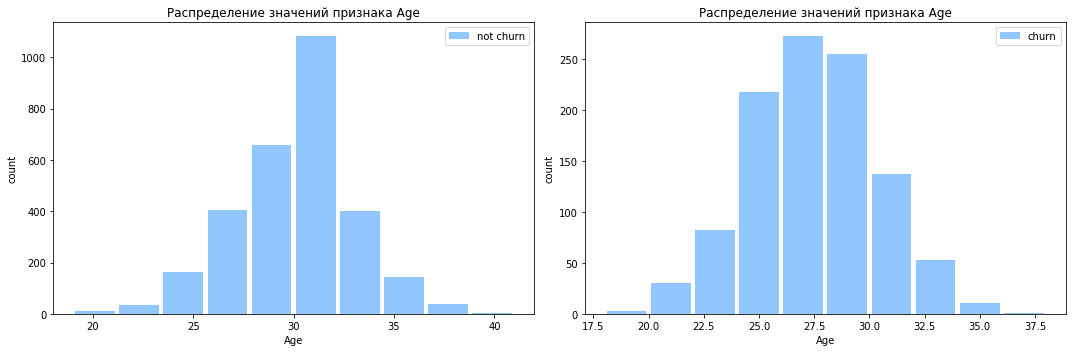

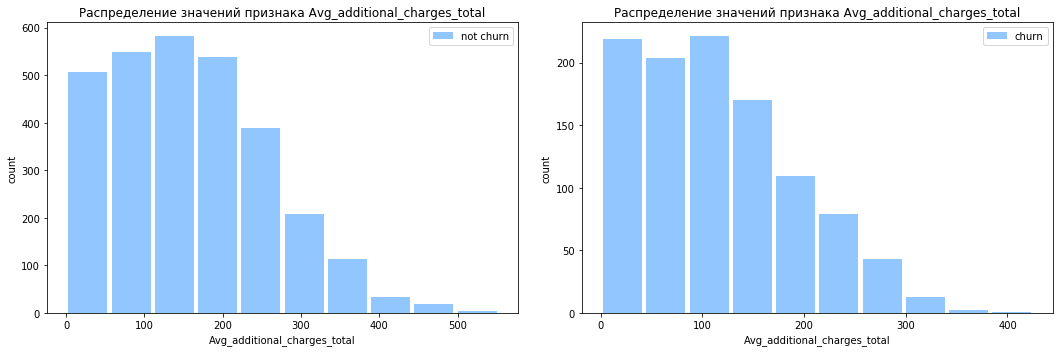

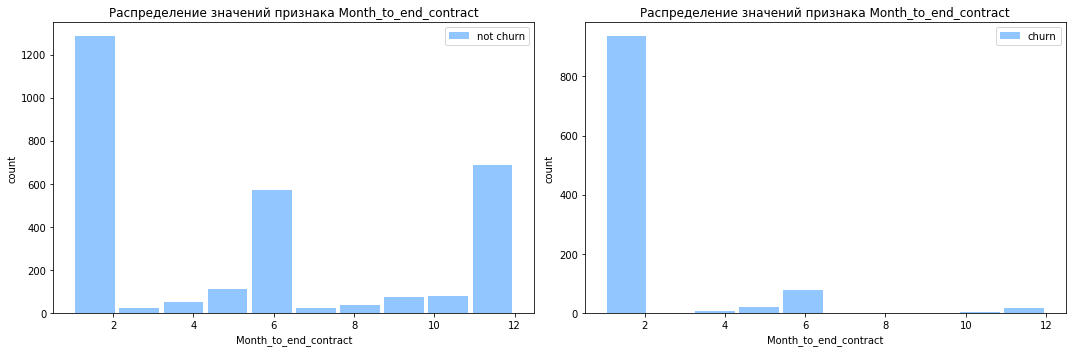

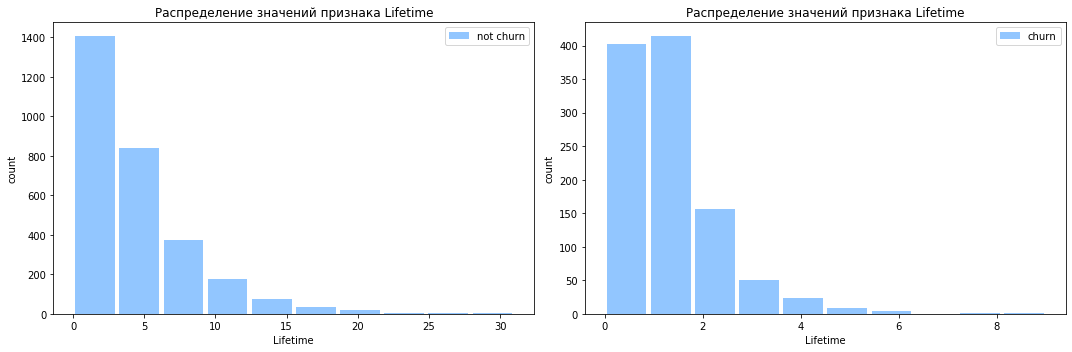

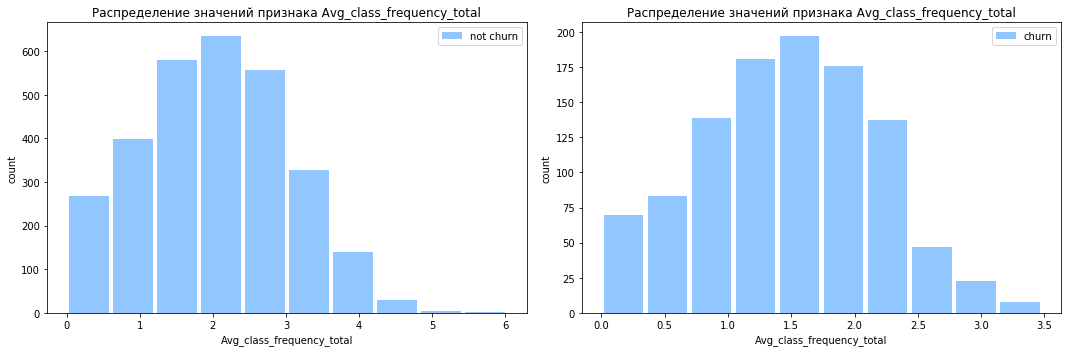

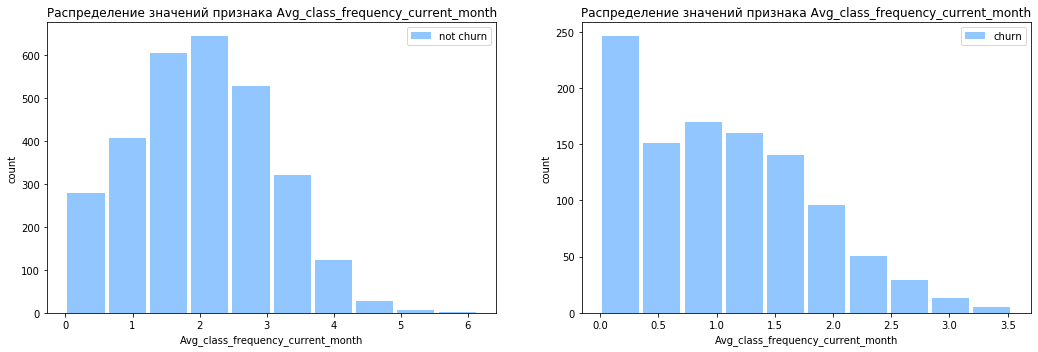

In [ ]:
for column in gym_churn.drop('Churn', axis=1).columns:
    fig, (ax,ax1) = plt.subplots(1, 2, figsize=(15,5))
    ax.hist(gym_churn.query('Churn == 0')[column], rwidth=0.9, label='not churn')
    ax.set_xlabel(column)
    ax.set_ylabel('count')
    ax.set_title('Распределение значений признака ' + column)
    ax.legend()
    ax1.hist(gym_churn.query('Churn == 1')[column], rwidth=0.9, label='churn')
    ax1.set_xlabel(column)
    ax1.set_ylabel('count')
    ax1.set_title('Распределение значений признака ' + column)
    ax1.legend()
    plt.tight_layout()
    plt.show()

Как видим главные отличия сравниваемых групп в признаках: срок контракта, компания-партер, лайфтайм, среднее количество посещений в неделю. 
Если коротко, то клиенты, которые "уходят" чаще всего имеют месячные абонементы, посещают фитнес-центр меньше 2-х раз в неделю, средний возраст таких клиентов распределен около 27 лет. В свою очередь клиенты группы "not churn" имеют более продолжительные абонементы, чаще посещают групповые занятия, возраст около 30 лет, посещают фитнес-клуб от 2-х раз в неделю.
Также отметим, что такие признаки, как пол, промо от друга, наличие контактного телефона имеют схожие распределения, что говорит о малом влиянии этих признаков на факт оттока

* Посмотрим на матрицу корреляций.

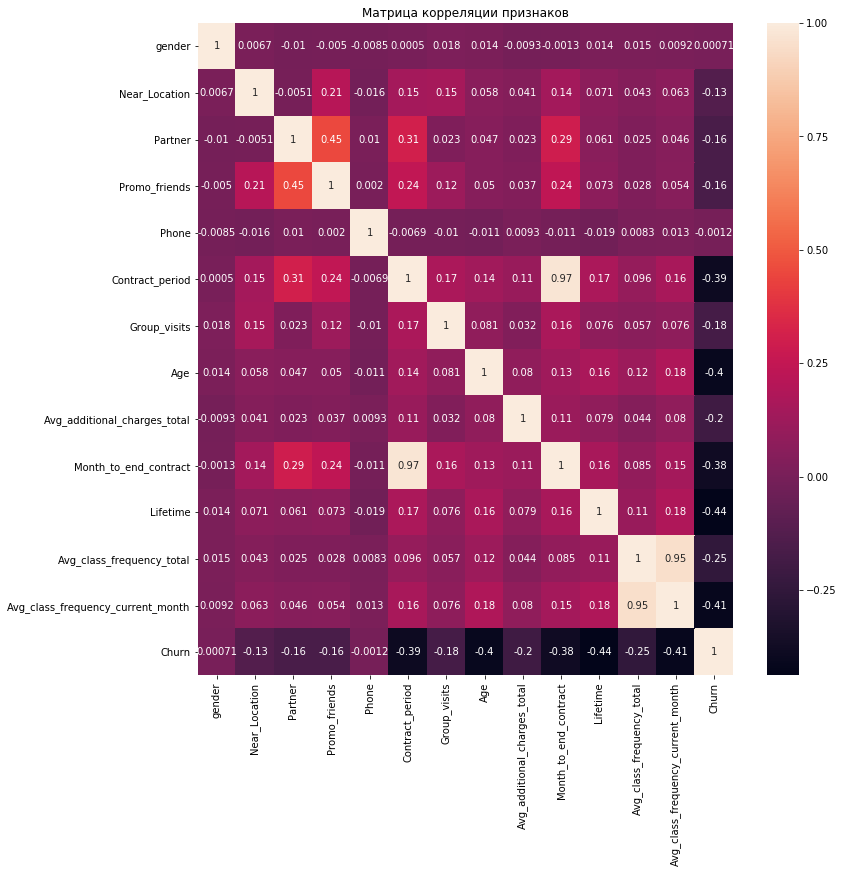

In [ ]:
cm = gym_churn.corr()
plt.figure(figsize=(12,12))
sns.heatmap(data=cm, annot=True)
plt.title('Матрица корреляции признаков')
plt.show()

Ожидаемо такие признаки как средняя частота посещения за предыдущий месяц и средняя за все время сильно коррелируют. Также количество месяцев до окончания контракта и период контракта также сильно коррелирует. Эти признаки придется исключить для построения модели прогнозирования.

Также на этом этапе можно сделать несколько промежуточных выводов:
1. Сильной корреляции между признаками и целевой переменной нет. Это значит, что все эти признаки подходят для построения ML модели.
2. Некоторые признаки сильно коррелируют между собой, что говорит о необходимости исключения из выборки для построения модели и ее обучения.
3. Так как мы прогнозируем не временные ряды, то для деления выборки будем использовать случайное разбиение.
4. По распределениям значений в двух группах (churn и not churn) можно предположить и наибольшем вкладе таких признаков как: Partner, Contract period, Group visit, Avg_class_frequency_total на модель.

## Модель прогнозирования оттока клиентов

Для логистической регрессии нет необходимости приводить данные к стандартизированным данным, поэтому будем работать с исходными данными. Для начала создадим матрицу признаков - X и целевую переменную - y

In [ ]:
X = gym_churn.drop(['Churn', 'Month_to_end_contract', 'Avg_class_frequency_current_month'], axis=1)
y = gym_churn['Churn']

Разобьем данные на обучающую и валидационную

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Стандартизируем данные

In [ ]:
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)

Преобразуем наши данные с учетом стандартизации

In [ ]:
X_test_st = scaler.transform(X_test)

Задаем алгоритм для нашей модели

In [ ]:
lr_model = LogisticRegression(random_state=0, solver='liblinear')

Обучим модель для логистической регрессии и сделаем предсказания.

In [ ]:
lr_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Делаем прогнозы

In [ ]:
lr_predictions = lr_model.predict(X_test)
lr_probabilities = lr_model.predict_proba(X_test)[:, 1]

Теперь проделаем процедуру для алгоритма "случайный лес" и далее выведем метрики для двух моделей.

In [ ]:
rf_model = RandomForestClassifier(n_estimators = 100, random_state=0)
rf_model.fit(X_train_st, y_train)
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]

In [ ]:
def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))

In [ ]:
print_all_metrics(y_test, lr_predictions, lr_probabilities, title='Метрики для модели логистической регрессии')

Метрики для модели логистической регрессии
	Accuracy: 0.88
	Precision: 0.76
	Recall: 0.77


In [ ]:
print_all_metrics(y_test, rf_predictions, rf_probabilities, title='Метрики для модели случайного леса')

Метрики для модели случайного леса
	Accuracy: 0.89
	Precision: 0.79
	Recall: 0.76


Как видим модель случайного леса отработала немного лучше. Практически все метрики ближе к единице, кроме Recall.

В рамках нашей бизнес задачи - определения по признакам клиентов, которые с большей вероятностью перейдут в "отток" в ближайшее время - можно сказать, что целевая метрика Precision, которая отражает какая доля прогнозов относительно "1" верна. Т.к для нас важно именно срабатывание модели, чтобы работать с этим клиентом дополнительно для его удержания. Поэтому для оценки решения нашей задачи метрика Precision подходит больше всех. Случайный лес по этой метрике лучше логистической регрессии.

## Кластеризация клиентов

Предварительно стандиртизируем признаки.

In [ ]:
x_sc = scaler.fit_transform(X)

Теперь нарисуем дендрограмму.

In [ ]:
linked = linkage(x_sc, method = 'ward')

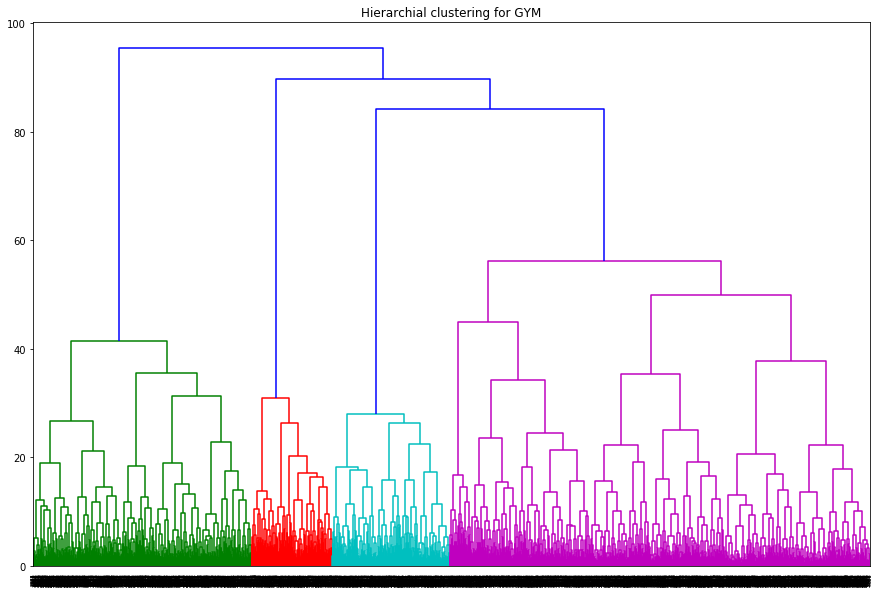

In [ ]:
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM')
plt.show()

Алгоритм показывает разделение графика на 4 цвета. Однако видно, что кластер фиолетового цвета можно разделить еще на 2 (расстояние от крайних агломератов довольно существенное для разделения) и таким образом получится 5 кластеров. Тогда возьмем для алгоритма K-Means количество кластеров равное 5 и проведем расчеты.

In [ ]:
km = KMeans(n_clusters = 5, random_state=0)
labels = km.fit_predict(x_sc)

Сохраняем индексы групп в наш датасет и найдем средние значения признаков для кластеров.

In [ ]:
gym_churn['label'] = labels

In [ ]:
gym_churn.groupby('label').mean().T

label,0,1,2,3,4
gender,0.50,0.49,0.51,0.54,0.52
Near_Location,0.00,1.00,1.00,1.00,0.86
Partner,0.49,0.96,0.24,0.25,0.47
Promo_friends,0.08,0.89,0.06,0.08,0.31
Phone,1.00,1.00,1.00,1.00,0.00
Contract_period,3.03,7.66,2.82,4.53,4.78
Group_visits,0.24,0.46,0.00,1.00,0.43
Age,28.72,29.54,28.77,29.54,29.30
Avg_additional_charges_total,137.54,155.86,143.38,148.09,144.21
Month_to_end_contract,2.85,6.99,2.65,4.17,4.47


* Группа "1" имеет самую большую долю ударжанных клиентов ("not churn"). 
* Для этой группы характерно самое большое среднее количество посещения фитнес-клуба в неделю - 1.98. * Также видим, что средний период контракта составляет 7.66, что значительно выше, чем у других кластеров. У кластера "0" с самой большой долей клиентов в оттоке (0.40) это значение 3.03.
* Также выделяются признаки Partner и Promo_friends. 96 и 89 % клиентов группы "1" имеют партнерскую программу или промо-код друга. Эти параметры значительно повышают лояльность клиентов к фитнес-клубу.
* Отметим, что у кластера "0" клиенты живут и работают не в том же районе, где находится фитнес-клуб. Что подверждает важность этого признака для удержания клиентов. 

Посмотрим распределение признаков по кластерам. Для категориальных значений построим график по количеству значений, а для непрерывных значений посмотрим диаграмму разброса.

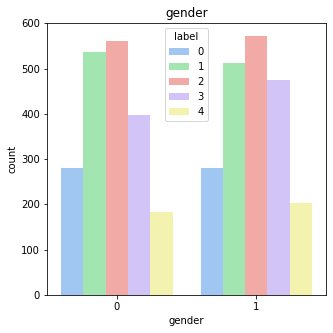

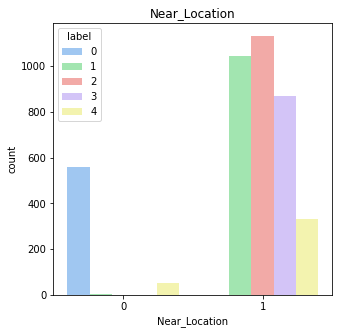

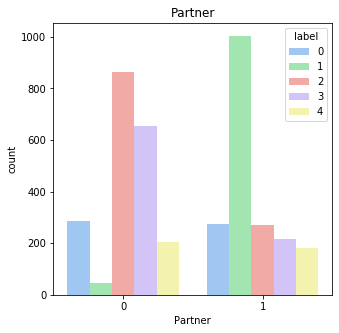

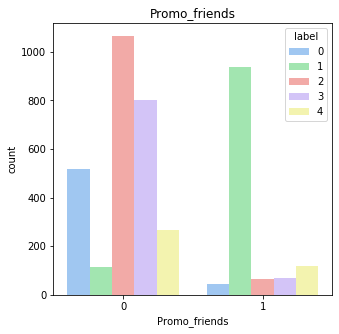

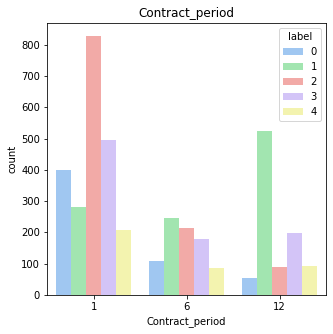

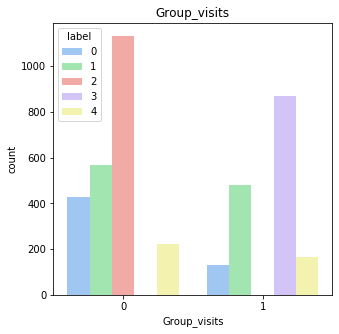

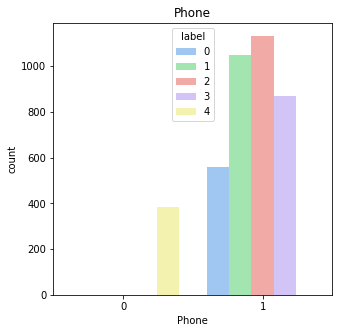

In [ ]:
for column in ['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Contract_period', 'Group_visits', 'Phone']:
    plt.figure(figsize=(5, 5))
    sns.countplot(x = gym_churn[column], hue='label', data=gym_churn)
    plt.title(column)
    plt.show()

In [ ]:
gym_churn.columns

Index(['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone',
       'Contract_period', 'Group_visits', 'Age',
       'Avg_additional_charges_total', 'Month_to_end_contract', 'Lifetime',
       'Avg_class_frequency_total', 'Avg_class_frequency_current_month',
       'Churn', 'label'],
      dtype='object')

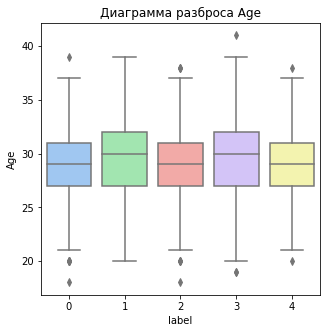

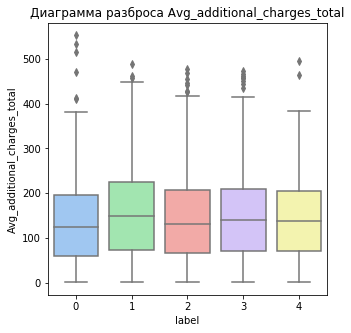

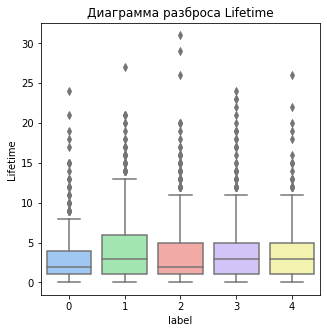

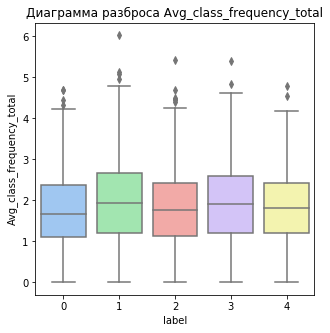

In [ ]:
for column in ['Age', 'Avg_additional_charges_total', 'Lifetime', 'Avg_class_frequency_total']:
    plt.figure(figsize=(5, 5))
    sns.boxplot(x = 'label', y = gym_churn[column], data = gym_churn)
    plt.title('Диаграмма разброса ' + column)
    plt.show()

По распределению признаков для этих групп можно выделить те, которые оказываю наибольшее влияние на факт удержания клиентов. Близость к фитнес клубу важна, также как и срок абонемента, т.е клиенты с длительным абонементом с большей вероятностью продолжают пользоваться услугами. Также видим, что наличие программы лояльность для компании-партнера также положительно сказыватся на удержании клинета. Если говорить о портрете клиента, который с большей вероятностью будет иметь длительный лайфтайм, то это: возраст около 30 лет, живет или работает около фитнес-клуба, вероятнее всего участвует в программе лояльности для компаний-партнеров, срок абонемента от 6 месяцев, посещает фитнес-клуб 2 раза в неделю.

Выведем долю оттока клиентов для каждого кластера.

In [ ]:
gym_churn.groupby('label')['Churn'].mean()

label
0   0.40
1   0.12
2   0.38
3   0.20
4   0.27
Name: Churn, dtype: float64

## 3. Выводы и  рекомендации

* Такие признаки как: срок абонемента, удаленность от фитнес-центра, наличие программы лояльности для компании пратнера, частота посещения в неделю сильно оказывают влияние на факт оттока клиентов. 
* Типичный портрет клиента с высокой вероятностью оттока в следующем месяце: возраст 27 и меньше, короткий срок абонемента 2 месяца и меньше, редко посещает фитнес-клуб - в среднем меньше 2-х раз в неделю, редко посещают групповые занятия.

**Рекомендации**

1. Повысить узнаваемость фитнес-клуба в пределах района: наружная реклама, промо-компании.
2. B2b продажи и выгодные партнерские программы дают хороших, лояльных клиентов.
3. Повышать вовлекаемость клиентов: широкий выбор групповых программ
4. Делать более выгодные условия для абонементов с длительным сроком.